# Attendance analysis

In [1]:
#load modules
import pandas as pd
import numpy as np
import os

In [2]:
#set up R environment and library
%load_ext rpy2.ipython

In [169]:
%R library(ggplot2)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [4]:
%R library(scales)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [5]:
#function to make df readable into R
def sametype(df):
    cols = df.columns
    for index, val in enumerate(cols):
        if df[val].dtype == 'O':
            df[val] = df[val].astype('str')
    return df

## Data

### Load Data

In [61]:
#read DATA in
#first read in attendance data
attendance_df = pd.read_csv('../data/historical/HomeGames.csv')
#read in franchises for active or not
franchises_df = pd.read_csv('../data/historical/TeamsFranchises.csv')
#park info
parks_df = pd.read_csv('../data/historical/Parks.csv')
#team info
teams_df = pd.read_csv('../data/historical/Teams.csv')
#postseason stats
post_season_df = pd.read_csv('../data/historical/SeriesPost.csv')
#mycsv
stadium_historic = pd.read_csv('../data/stadiums/past_present_stadiums.csv', parse_dates=['year_opened'])

### Clean Data

In [63]:
#active franchises
active_franchises_df = franchises_df.loc[franchises_df.active == 'Y']

#only after 1968 for 50 years of data
active_teams_df = teams_df.loc[(teams_df.franchID.isin(active_franchises_df.franchID)) & (teams_df.yearID > 1968)]
active_teams_df = active_teams_df[['yearID', 'lgID', 'teamID', 'franchID', 'Rank', 'W', 'name', 'park', 'attendance']]

#need to see if made playoffs and worldseries that year
with_series = pd.merge(active_teams_df, post_season_df[['yearID', 'round', 'teamIDwinner']], how = 'left', right_on = ['yearID', 'teamIDwinner'], left_on = ['yearID', 'teamID'])
with_series = pd.merge(with_series, post_season_df[['yearID', 'round', 'teamIDloser']], how = 'left', right_on = ['yearID', 'teamIDloser'], left_on = ['yearID', 'teamID'])
with_series.rename(columns={'round_x':'round won', 'round_y':'round lost'}, inplace=True)
with_series = with_series.drop(['teamIDwinner', 'teamIDloser'], axis=1)

#with_series
with_series = sametype(with_series)
with_series.loc[(with_series['round won']=='nan') & (with_series['round lost']=='nan'), 'Made_Playoffs'] = 'No'
with_series.loc[(with_series['Made_Playoffs'].isna()), 'Made_Playoffs'] = 'Yes'

#average the wins and attendance in a dataframe
mean_win_attend = active_teams_df.loc[active_teams_df.yearID > 1969][['franchID', 'W', 'attendance']].groupby(['franchID']).mean().reset_index()

#trim analysis down to teams that did better than league average
pert_teams = mean_win_attend.loc[mean_win_attend.W > mean_win_attend['W'].mean()]['franchID'].reset_index()
#take arizona out since formed 1998
pert_teams = pert_teams.loc[pert_teams.franchID != "ARI"]['franchID']
pert_active_team_df = active_teams_df.loc[active_teams_df.franchID.isin(pert_teams)]
pert_series = with_series.loc[with_series.franchID.isin(pert_teams)]

#start creating final table with 11 teams and playoff or not each year
t2 = pd.merge(pert_active_team_df, pert_series[['yearID', 'lgID', 'teamID', 'franchID', 'Made_Playoffs']], how = 'left')

#add in stadium info
stadium_historic['year_opened'] = stadium_historic.year_opened.dt.year
pert_df = pd.merge(t2,stadium_historic, how ='left', right_on = ['franchID', 'Stadium_name'],left_on = ['franchID', 'park'])
pert_df = pert_df.drop(['Stadium_name'], axis=1)
pert_df['prev_playoff'] = pert_df.sort_values(['franchID', 'yearID']).shift(1)['Made_Playoffs']
#start from 1970 becuase of shift function earlier
pert_df = pert_df.loc[pert_df.yearID > 1969]
pert_df = pert_df.drop_duplicates()
#percent stadium is filled
pert_df['percent_filled'] = (pert_df.attendance/81)/pert_df.capacity
#add in column for new stadium
pert_df.loc[pert_df.yearID == pert_df.year_opened, 'new_stadium'] = 'yes'
pert_df.loc[(pert_df.new_stadium.isna()), 'new_stadium'] = 'no'

#for vertical line
new_stadium = pert_df.loc[pert_df.new_stadium == 'yes']

### Data exploration

In [168]:
pert_df.loc[pert_df['Made_Playoffs'] == 'No'].percent_filled.mean()

0.5304146451526583

In [66]:
pert_df.loc[pert_df['Made_Playoffs'] == 'Yes'].percent_filled.mean()

0.7005870103818628

In [47]:
(0.7005870103818628 - 0.5304146451526583)/(0.5304146451526583)*100

32.08289340884002

In [166]:
pert_df.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,Made_Playoffs,year_opened,capacity,prev_playoff,percent_filled,new_stadium
11,1970,NL,ATL,ATL,5,76,Atlanta Braves,Atlanta-Fulton County Stadium,1078848.0,No,1966.0,52007.0,Yes,0.256102,no
12,1970,AL,BAL,BAL,1,108,Baltimore Orioles,Memorial Stadium,1057069.0,Yes,1954.0,47855.0,Yes,0.272704,no
14,1970,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1595278.0,No,1912.0,37755.0,No,0.521647,no
15,1970,AL,CAL,ANA,3,86,California Angels,Anaheim Stadium,1077741.0,No,1966.0,45517.0,No,0.292318,no
16,1970,NL,CIN,CIN,1,102,Cincinnati Reds,Crosley Field/Riverfront Stadium,1803568.0,Yes,1912.0,29488.0,No,0.755096,no


### Data Visulization

In [67]:
%R -i pert_df

In [68]:
%R -i new_stadium

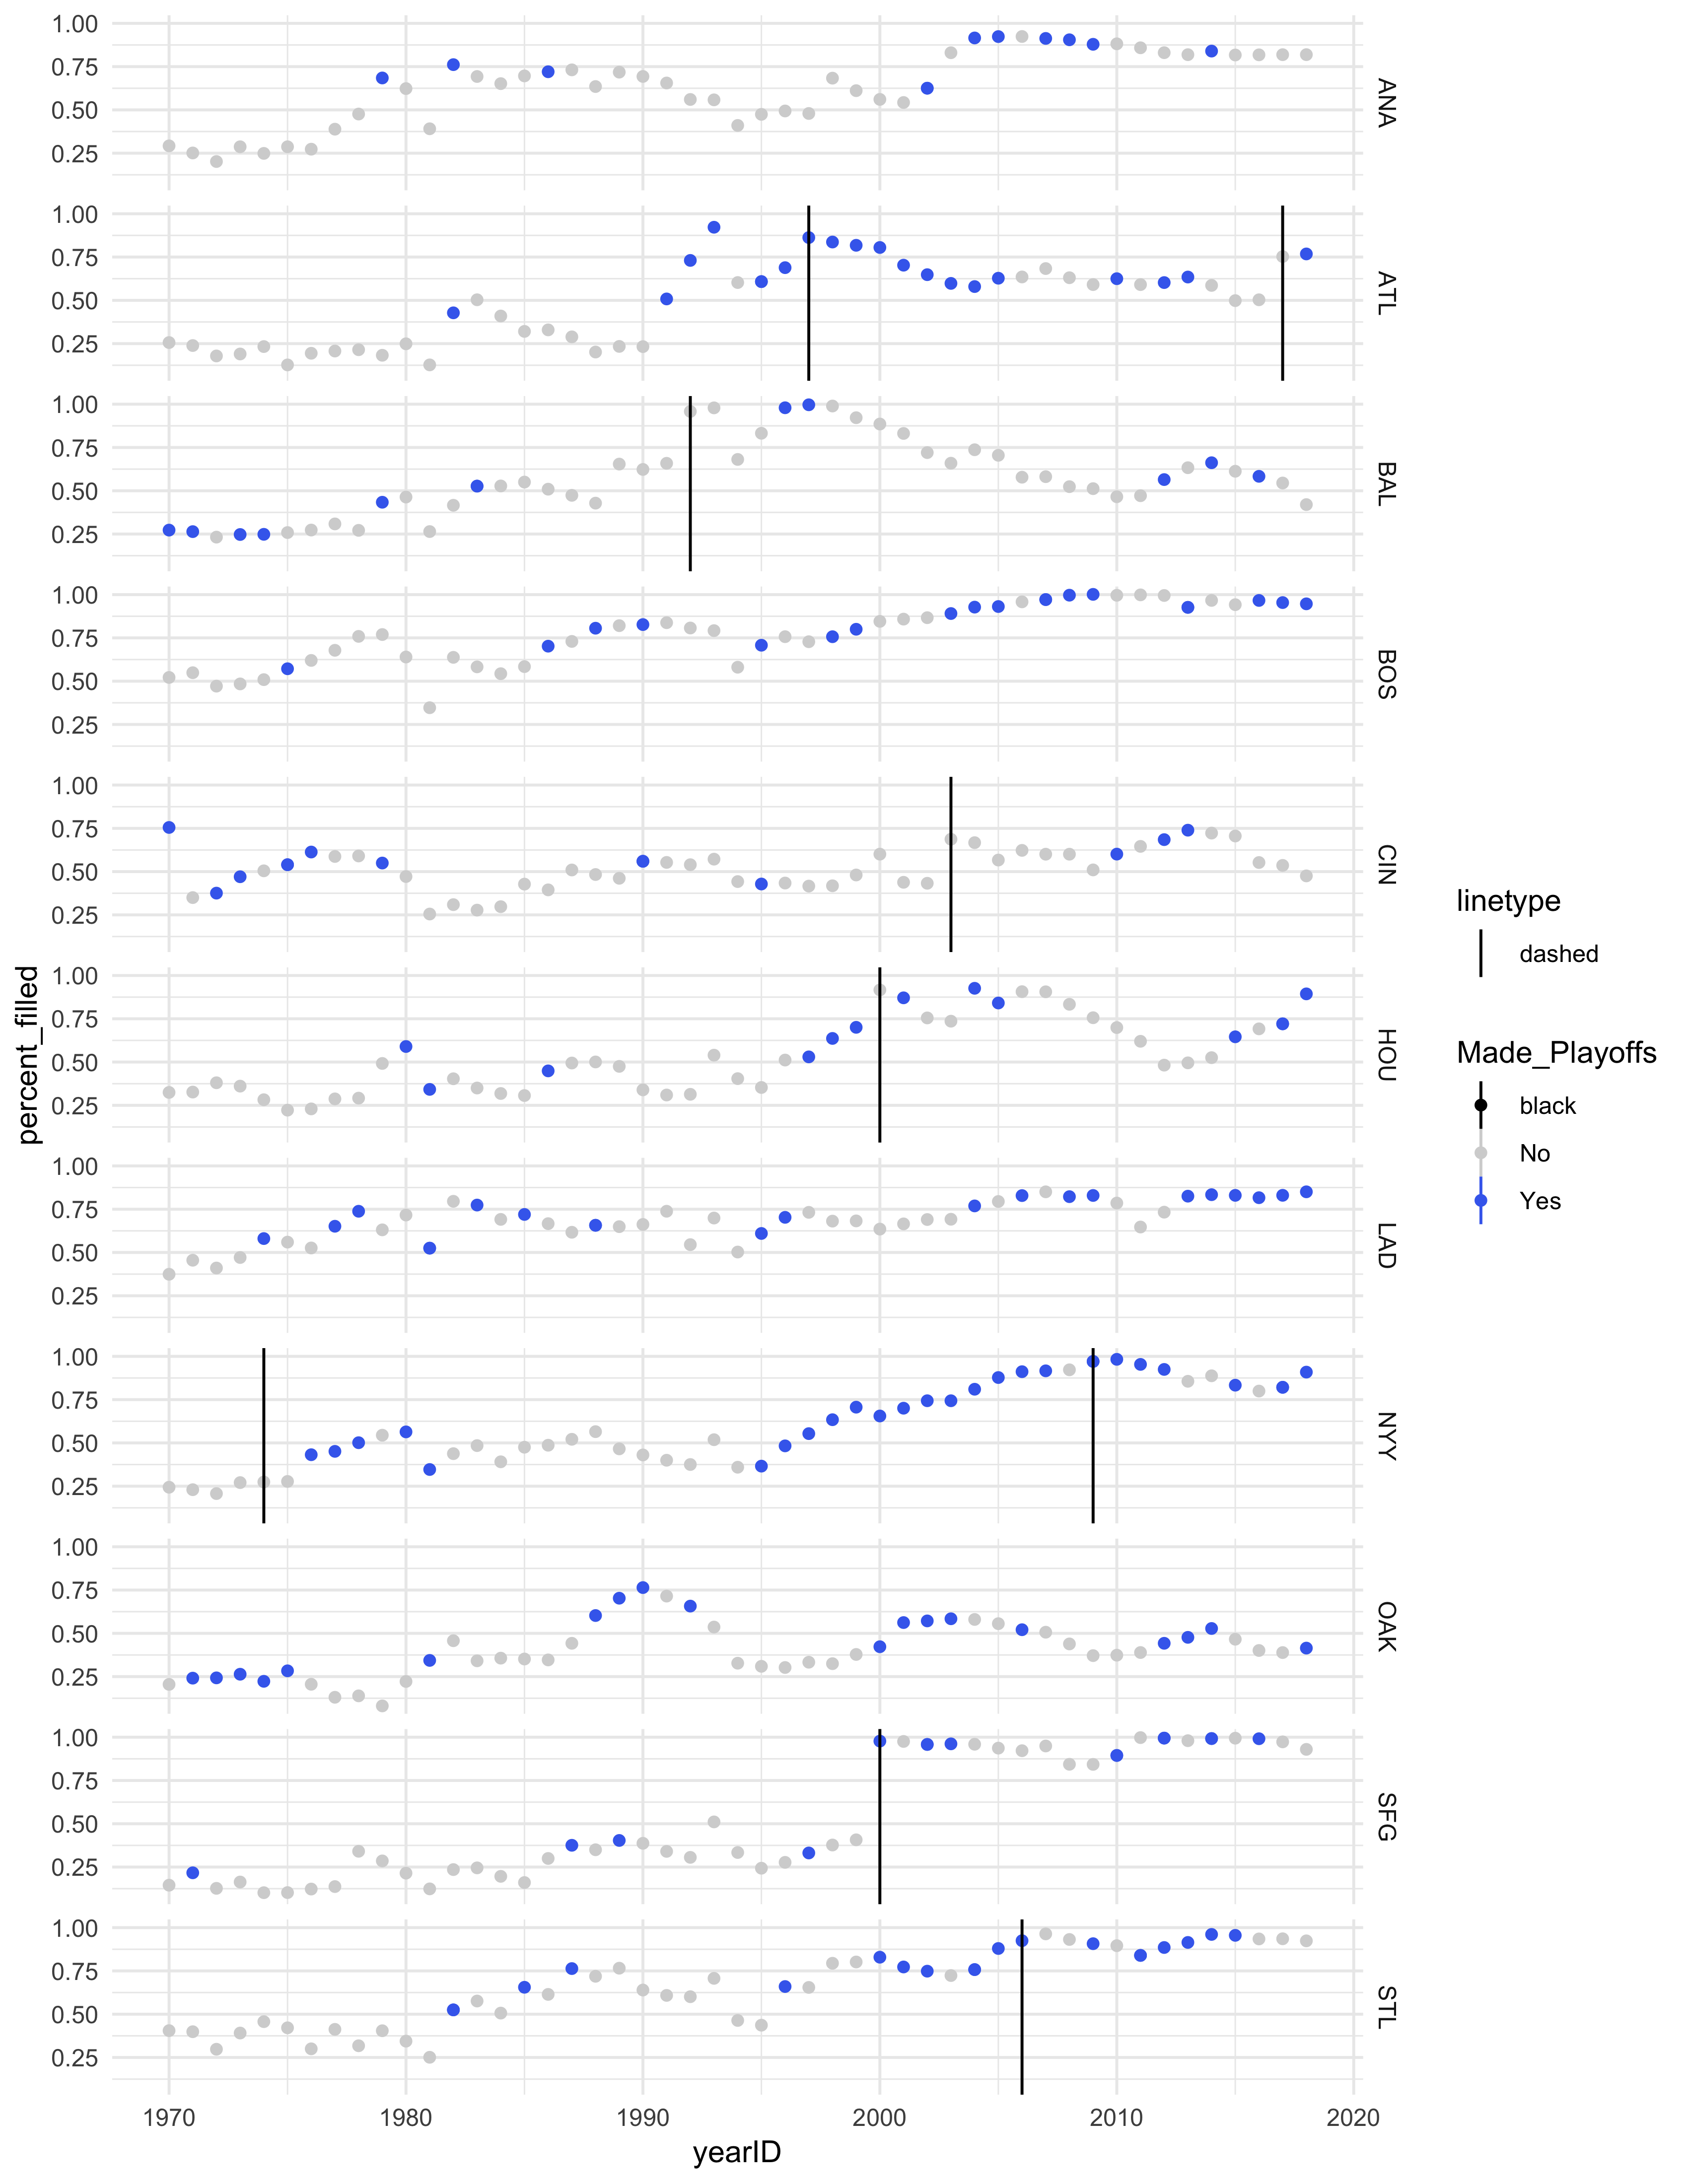

In [75]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot(pert_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = Made_Playoffs), size = 1.5) + 
    geom_vline(data = new_stadium, aes(xintercept = yearID, linetype = 'dashed', colour = 'black')) + 
    facet_grid(rows = vars(franchID)) + 
    theme_minimal() +
    scale_colour_manual(values = c("black", "grey83", "royalblue2"))
    
#ggsave('../images/attend_percentage.pdf')

In [71]:
yanks_df = pert_df.loc[pert_df.franchID == 'NYY']

In [72]:
%R -i yanks_df
#only do yanks playoffs
#make labels into 

In [165]:
%%R -w 11 -h 7 --units in -r 400

ggplot(yanks_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = Made_Playoffs), size = 1.5) + 
    theme_minimal() +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent of Stadium Filled Over the Season\n") +
    xlab("\nMLB season") + 
    ggtitle('NY Yankees Attendance Increases During Playoff Seasons') +
    scale_color_manual(values = c("gray", "#3b7d8d")) + labs(colour = 'Made Playoffs') +
    theme(plot.title = element_text(size = 20, face = "bold")) +
    scale_x_continuous(limits = c(1970,2021), breaks = seq(1970,2021,10)) 
ggsave('../images/yanks_playoff.png')

R[write to console]: Saving 11 x 7 in image



In [78]:
astro_df = pert_df.loc[pert_df.franchID == 'HOU']

In [79]:
%R -i astro_df
#only do houston playoffs

In [164]:
%%R -w 11 -h 7 --units in -r 400

ggplot(astro_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = Made_Playoffs), size = 1.5) + 
    theme_minimal() +
    scale_colour_manual(values = c("grey", "#3b7d8d")) +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent of Stadium Filled Over the Season\n") +
    xlab("\nMLB season") + ggtitle('Houston Astros Attendance Increases During Playoff Seasons') + labs(colour = 'Made Playoffs') +
    theme(legend.position = "none", plot.title = element_text(size = 20, face = "bold")) +
    scale_x_continuous(limits = c(1970,2021), breaks = seq(1970,2021,10)) 

ggsave('../images/astros_playoff.png')

R[write to console]: Saving 11 x 7 in image



In [82]:
#houston playoff and stadium
astro_new_stad = new_stadium.loc[new_stadium.franchID == 'HOU']

In [83]:
%R -i astro_new_stad

In [163]:
%%R -w 11 -h 7 --units in -r 400

ggplot(astro_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = Made_Playoffs), size = 1.5) + 
    theme_minimal() +
    scale_colour_manual(values = c("grey", "#3b7d8d")) +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent of Stadium Filled Over the Season\n") +
    xlab("\nMLB season") + ggtitle('Houston Astros Attendance Increases During Playoff Seasons') +
    geom_vline(data = astro_new_stad, aes(xintercept = yearID), linetype = 'dashed', colour = 'black') +
    annotate("text", x = 2004, y = .23, label = "New Stadium", size = 5, colour = "firebrick4", fontface = 'bold', alpha = .7) +
    labs(colour = 'Made Playoffs') + theme(legend.position = "none", plot.title = element_text(size = 20, face = "bold")) +
    scale_x_continuous(limits = c(1970,2021), breaks = seq(1970,2021,10)) 

ggsave('../images/astros_playoff_newstad.png')

R[write to console]: Saving 11 x 7 in image

